# Profiling

In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.utils import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset

%load_ext pyinstrument
%load_ext line_profiler

# Information system and libraries

In [3]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.11.10
scikit-learn version: 1.6.1
skforecast version: 0.16.0
pandas version: 2.2.3
numpy version: 2.1.3
scipy version: 1.15.2
psutil version: 7.0.0

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19045-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19045
Number of physical cores: 8
Number of logical cores: 16


# ForecasterAutoregMultiSeries

In [4]:
n_series = 500
len_series = (2000, 5000)
series_dict = {}
rng = np.random.default_rng(321)
for i in range(n_series):
    n = rng.integers(low=len_series[0], high=len_series[1])
    series_dict[f'series_{i}'] = pd.Series(
        data = rng.normal(loc=20, scale=5, size=n),
        index=pd.date_range(
            start='2010-01-01',
            periods=n,
            freq='h'
        ),
        name=f'series_{i}'
    )

exog_dict = {}
rng = np.random.default_rng(321)
for k in series_dict.keys():
    exog = pd.DataFrame(
            index=series_dict[k].index
            )
    exog['day_of_week'] = exog.index.dayofweek
    exog['week_of_year'] = exog.index.isocalendar().week.astype(int)
    exog['month'] = exog.index.month
    exog_dict[k] = exog


print(f"Range of dates: "
    f"{np.min([series_dict[k].index.min() for k in series_dict.keys()])} - "
    f"{np.max([series_dict[k].index.max() for k in series_dict.keys()])}"
)

Range of dates: 2010-01-01 00:00:00 - 2010-07-27 21:00:00


In [5]:
end_train = '2010-06-01 00:00:00'

In [6]:
# Forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=8520, verbose=-1),
    lags=50,
    # transformer_series=StandardScaler(),
    # transformer_exog=StandardScaler(),
    encoding="ordinal"
)

In [18]:
# %%timeit

# forecaster.fit(series=series_dict, exog=exog_dict)

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:22:25  Samples:  2245
 /_//_/// /_\ / //_// / //_'/ //     Duration: 10.922    CPU time: 48.219
/   _/                      v5.0.0

Cell [28]

10.921 <module>  ..\..\AppData\Local\Temp\ipykernel_23312\3804324935.py:1
`- 10.919 ForecasterRecursiveMultiSeries.fit  skforecast\recursive\_forecaster_recursive_multiseries.py:1637
   |- 5.450 LGBMRegressor.fit  lightgbm\sklearn.py:1172
   |     [14 frames hidden]  lightgbm, <built-in>, pandas
   |        3.770 Booster.update  lightgbm\basic.py:4073
   |- 2.203 ForecasterRecursiveMultiSeries._create_train_X_y  <string>:2
   |  |- 0.754 FastOrdinalEncoder.fit_transform  <string>:65
   |  |  `- 0.703 FastOrdinalEncoder.fit  <string>:30
   |  |     `- 0.703 unique  numpy\lib\_arraysetops_impl.py:145
   |  |           [2 frames hidden]  numpy, <built-in>
   |  |- 0.483 ForecasterRecursiveMultiSeries._create_train_X_y_single_series  skforecast\recursive\_forecaster_recursive_multiseries.py:836
   |  |  |- 0.207 ForecasterRecursiveMultiSeries._create_lags  skforecast\recursive\_forecaster_recursive_multiseries.py:724
   |  |  `- 0.189 DataFrame.__setitem__  pandas\core\frame.py:4271
   |  |        [3 frames hidden]  pandas
   |  |- 0.463 concat  pandas\core\reshape\concat.py:157
   |  |     [8 frames hidden]  pandas, <built-in>
   |  |- 0.174 check_preprocess_series  skforecast\utils\utils.py:2393
   |  |  `- 0.130 <dictcomp>  skforecast\utils\utils.py:2440
   |  |     `- 0.130 Series.copy  pandas\core\generic.py:6662
   |  |           [3 frames hidden]  pandas
   |  `- 0.144 check_preprocess_exog_multiseries  skforecast\utils\utils.py:2495
   |- 1.179 LGBMRegressor.predict  lightgbm\sklearn.py:992
   |     [11 frames hidden]  lightgbm, <built-in>, pandas
   |- 0.986 [self]  skforecast\recursive\_forecaster_recursive_multiseries.py
   |- 0.855 Series.__getitem__  pandas\core\series.py:1095
   |     [5 frames hidden]  pandas
   `- 0.111 <dictcomp>  skforecast\recursive\_forecaster_recursive_multiseries.py:1764
      `- 0.111 DatetimeIndex.__getitem__  pandas\core\indexes\base.py:5373
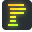

In [28]:
%%pyinstrument

forecaster.fit(series=series_dict, exog=exog_dict)

In [29]:
# Profiling fit()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster.fit(series=series, exog=exog)

%lprun -f forecaster.fit funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-07 s

Total time: 10.8929 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: fit at line 1637

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1637                                           
  1638                                           
  1639                                               def fit(
  1640                                                   self,
  1641                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
  1642                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  1643                                                   store_last_window: bool | list[str] = True,
  1644                                                   store_in_sample_residuals: bool = False,
  1645                                                   random_state: int = 123,
  16

In [7]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster._create_train_X_y(series=series, exog=exog)

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-07 s

Total time: 2.86437 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_train_X_y at line 962

Line #      Hits         Time  Per Hit   % Time  Line Contents
   962                                               def _create_train_X_y(
   963                                                   self,
   964                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   965                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
   966                                                   store_last_window: bool | list[str] = True,
   967                                               ) -> tuple[
   968                                                   pd.DataFrame,
   969                                                   pd.Series,
   970                                               

In [11]:
# Profiling _create_train_X_y_single_series()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    (
    X_train_autoreg,
    X_train_window_features_names_out_,
    X_train_exog,
    y_train
) = forecaster._create_train_X_y_single_series(
        y = series,
        exog = exog,
        ignore_exog = False,
    )

%lprun -f forecaster._create_train_X_y_single_series funt_to_profile(forecaster, series_dict['series_0'], exog_dict['series_0'])

Timer unit: 1e-09 s

Total time: 0.0023337 s
File: /home/ximo/GitHub/skforecast/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: _create_train_X_y_single_series at line 836

Line #      Hits         Time  Per Hit   % Time  Line Contents
   836                                               def _create_train_X_y_single_series(
   837                                                   self,
   838                                                   y: pd.Series,
   839                                                   ignore_exog: bool,
   840                                                   exog: pd.DataFrame | None = None
   841                                               ) -> tuple[pd.DataFrame, list[str], pd.DataFrame, pd.Series]:
   842                                                   """
   843                                                   Create training matrices from univariate time series and exogenous
   844                                                

In [ ]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    forecaster.predict(steps=steps, exog=exog, suppress_warnings=True)

%lprun -f forecaster.predict funt_to_profile(forecaster, 7, exog_dict_valid)

Timer unit: 1e-09 s

Total time: 36.6131 s
File: /home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py
Function: predict at line 1537

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1537                                               def predict(
  1538                                                   self,
  1539                                                   steps: int,
  1540                                                   levels: Optional[Union[str, list]]=None,
  1541                                                   last_window: Optional[pd.DataFrame]=None,
  1542                                                   exog: Optional[Union[pd.Series, pd.DataFrame, dict]]=None,
  1543                                                   suppress_warnings: bool=False
  1544                                               ) -> pd.DataFrame:
  1545                                                   """
  1546                

: 

: 

: 

In [ ]:
# Functions to profile:
# ==============================================================================
# check_preprocess_exog_multiseries
# align_series_and_exog_multiseries
# _create_train_X_y_single_series
# _create_predict_inputs
# _recursive_predict

: 

: 

In [ ]:
# Profiling align_series_and_exog_multiseries()
# ==============================================================================
# def funt_to_profile(series_dict, input_series_is_dict, exog_dict):
#     align_series_and_exog_multiseries(
#         series_dict=series_dict,
#         input_series_is_dict=input_series_is_dict,
#         exog_dict = exog_dict,
#     )

# %lprun -f align_series_and_exog_multiseries funt_to_profile(series_dict_train, True, exog_dict_train)

: 

: 

In [ ]:
# # Profiling check_preprocess_exog_multiseries()
# # ==============================================================================
# series_indexes = {k: v.index for k, v  in series_dict_train.items()}
# series_col_names = list(series_dict_train.keys())

# def funt_to_profile(input_series_is_dict, series_indexes, series_col_names, exog, exog_dict):
#     check_preprocess_exog_multiseries(
#         input_series_is_dict = input_series_is_dict,
#         series_indexes = series_indexes,
#         series_col_names = series_col_names,
#         exog = exog_dict_train,
#         exog_dict = exog_dict_train,
#     )

# %lprun -f check_preprocess_exog_multiseries funt_to_profile(True, series_indexes, series_col_names, exog, exog_dict)

: 

: 

In [ ]:
import pandas as pd
import numpy as np
import time

def fun_original():
    pass

def fun_optimized_1():
    pass

start_time = time.time()
try:
    fun_original()
except TypeError as e:
    end_time = time.time()
    print(e)
finally:
    end_time = time.time()
print(f"Original code execution time: {end_time - start_time} seconds")

start_time = time.time()
try:
    fun_optimized_1()
except TypeError as e:
    end_time = time.time()
    print(e)
finally:
    end_time = time.time()
print(f"Optimized code 1 execution time: {end_time - start_time} seconds")


Original code execution time: 0.00015878677368164062 seconds
Optimized code 1 execution time: 0.00017976760864257812 seconds


: 

: 

In [6]:
import numpy as np
import time
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

class FastOrdinalEncoder:
    """
    Encode categorical features as an integer array. The input to this transformer should
    be an array-like of integers or strings, denoting the values taken on by categorical
    (discrete) features. The features are converted to ordinal integers. This results in
    a single column of integers (0 to n_categories - 1) per feature.

    Parameters
    ----------

    Attributes
    ----------
    categories_ : np.ndarray
        Unique categories in the data.
    category_map_ : dict
        Mapping of categories to integers.
    inverse_category_map_ : dict
        Mapping of integers to categories.
    unknown_value : int | float, default=-1
        Value to use for unknown categories.
    
    """


    def __init__(self, unknown_value: int | float = -1):

        self.unknown_value = unknown_value
        self.categories_ = None
        self.category_map_ = None
        self.inverse_category_map_ = None
        
    def fit(self, X: np.ndarray | pd.Series) -> None:
        """
        Fit the encoder to the unique categories in the data.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to fit the encoder.
        """

        self.categories_ = np.unique(X)
        self.category_map_ = {category: idx for idx, category in enumerate(self.categories_)}
        self.inverse_category_map_ = {idx: category for idx, category in enumerate(self.categories_)}
    
    def transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Transform the data to ordinal values using direct indexing.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to transform.

        Returns
        -------
        np.ndarray
            Transformed data with ordinal values.

        """

        if self.categories_ is None:
            raise ValueError("The encoder has not been fitted yet. Call 'fit' before 'transform'.")
        if not isinstance(X, (np.ndarray, pd.Series)):
            raise ValueError("Input data must be a numpy array or pandas Series.")
        
        encoded_data = pd.Series(X).map(self.category_map_).fillna(self.unknown_value).to_numpy()

        return encoded_data

    def fit_transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Fit encoder and transform the data.
        
        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to fit and transform.

        Returns
        -------
        np.ndarray
            Transformed data with ordinal values.
        """

        self.fit(X)
        
        return self.transform(X)
    
    def inverse_transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Inverse transform the encoded data back to original categories.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Encoded data to inverse transform.

        Returns
        -------
        np.ndarray
            Inverse transformed data with original categories.
        """
        if self.categories_ is None:
            raise ValueError("The encoder has not been fitted yet. Call 'fit' before 'inverse_transform'.")
        if not isinstance(X, (np.ndarray, pd.Series)):
            raise ValueError("Input data must be a numpy array or pandas Series.")
        
        inverse_encoded_data = pd.Series(X).map(self.inverse_category_map_).fillna(self.unknown_value).to_numpy()

        return inverse_encoded_data
    

# Create a large synthetic dataset of strings (categories)
np.random.seed(42)
categories = [f"category_{i}" for i in range(500)]
data = np.repeat(categories, 1000)
# Benchmark sklearn OrdinalEncoder
start_time = time.time()
sklearn_encoder = OrdinalEncoder()
sklearn_encoded_data = sklearn_encoder.fit_transform(data.reshape(-1, 1))
sklearn_time = time.time() - start_time
print(f"Sklearn OrdinalEncoder time: {sklearn_time:.4f} seconds")

# Benchmark FastOrdinalEncoder
start_time = time.time()
fast_encoder = FastOrdinalEncoder()
fast_encoded_data = fast_encoder.fit_transform(data)
fast_time = time.time() - start_time
print(f"FastOrdinalEncoder time: {fast_time:.4f} seconds")


# Check if the results are the same
assert np.array_equal(sklearn_encoded_data.flatten(), fast_encoded_data)
print("All encoders produced the same results.")

# check inverse transform
assert np.array_equal(data, fast_encoder.inverse_transform(fast_encoded_data))
print("Inverse transform works correctly.")



Sklearn OrdinalEncoder time: 0.3234 seconds
FastOrdinalEncoder time: 0.1352 seconds
All encoders produced the same results.
Inverse transform works correctly.


In [7]:
len(data)

500000

## FastEncoder 2

In [13]:
import numpy as np

class FastOrdinalEncoder2:
    """
    Encode categorical features as integer arrays using optimized operations.
    
    This transformer converts input array-like categorical features (numpy arrays, lists, or pandas Series)
    to ordinal integers. If the input contains unknown categories during transform, they are replaced with `unknown_value`.
    
    Parameters
    ----------
    unknown_value : int or float, default=-1
        Value to assign for unknown categories.
        
    Attributes
    ----------
    categories_ : np.ndarray
        Sorted unique categories seen in the data.
    """

    def __init__(self, unknown_value: int | float = -1):
        self.unknown_value = unknown_value
        self.categories_ = None

    def fit(self, X: np.ndarray | list | pd.Series) -> None:
        """
        Fit the encoder with unique categories from the data.
        
        Parameters
        ----------
        X : array-like (np.ndarray, list, or pandas Series)
            Input data to fit the encoder.
        """
        # Convert to numpy array regardless of input type
        if isinstance(X, pd.Series):
            X_arr = X.to_numpy()
        else:
            X_arr = np.asarray(X)
        # Use sorted unique categories for consistency with sklearn's OrdinalEncoder
        self.categories_ = np.unique(X_arr)

    def transform(self, X: np.ndarray | list | pd.Series) -> np.ndarray:
        """
        Transform the data to ordinal values.
        
        For pandas Series input, uses an optimized pd.Categorical mapping.
        
        Parameters
        ----------
        X : array-like (np.ndarray, list, or pandas Series)
            Input data to transform.
            
        Returns
        -------
        np.ndarray
            Array of ordinal encoded values.
        """
        if self.categories_ is None:
            raise ValueError("Encoder has not been fitted yet. Call 'fit' first.")

        if isinstance(X, pd.Series):
            # Use pd.Categorical, which is implemented in C and highly optimized.
            cat = pd.Categorical(X, categories=self.categories_, ordered=True)
            codes = cat.codes  # Unknown categories are coded as -1 by default.
            if self.unknown_value != -1:
                codes = np.where(codes == -1, self.unknown_value, codes)
            return codes
        else:
            X_arr = np.asarray(X)
            # Use np.searchsorted on sorted unique categories.
            indices = np.searchsorted(self.categories_, X_arr)
            valid = (indices < len(self.categories_)) & (self.categories_[indices] == X_arr)
            result = np.full(X_arr.shape, fill_value=self.unknown_value, dtype=int)
            result[valid] = indices[valid]
            return result

    def fit_transform(self, X: np.ndarray | list | pd.Series) -> np.ndarray:
        """
        Fit the encoder and transform the data.
        
        Parameters
        ----------
        X : array-like (np.ndarray, list, or pandas Series)
            Input data to fit and transform.
            
        Returns
        -------
        np.ndarray
            Array of ordinal encoded values.
        """
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X: np.ndarray | list | pd.Series) -> np.ndarray:
        """
        Inverse transform encoded values back to original categories.
        
        Parameters
        ----------
        X : array-like (np.ndarray, list, or pandas Series)
            Ordinal encoded data.
            
        Returns
        -------
        np.ndarray
            Array of original categories.
        """
        if self.categories_ is None:
            raise ValueError("Encoder has not been fitted yet. Call 'fit' first.")
        
        X_arr = np.asarray(X)
        result = np.empty(X_arr.shape, dtype=self.categories_.dtype)
        valid = (X_arr >= 0) & (X_arr < len(self.categories_))
        result[valid] = self.categories_[X_arr[valid]]
        result[~valid] = self.unknown_value
        return result

# Ejemplo y benchmark

import time

# Creamos un gran dataset sintético de cadenas (categorías)
np.random.seed(42)
categories = np.array([f"category_{i}" for i in range(500)], dtype=object)
data = pd.DataFrame(np.repeat(categories, 1000), columns=['y'])
data_re = np.repeat(categories, 10000).reshape(-1, 1)
data = np.repeat(categories, 10000)

# Benchmark con scikit-learn OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
start_time = time.time()
sklearn_encoder = OrdinalEncoder()
sklearn_encoded_data = sklearn_encoder.fit_transform(data_re)
sklearn_time = time.time() - start_time
print(f"Sklearn OrdinalEncoder time: {sklearn_time:.4f} seconds")

# Benchmark con FastOrdinalEncoder optimizado
start_time = time.time()
fast_encoder = FastOrdinalEncoder()
fast_encoded_data = fast_encoder.fit_transform(data)
fast_time = time.time() - start_time
print(f"FastOrdinalEncoder time: {fast_time:.4f} seconds")

# Benchmark con FastOrdinalEncoder optimizado
start_time = time.time()
fast_encoder_2 = FastOrdinalEncoder2()
fast_encoded_data_2 = fast_encoder_2.fit_transform(data)
fast_time = time.time() - start_time
print(f"FastOrdinalEncoder2 time: {fast_time:.4f} seconds")

# Verificamos que ambos produzcan el mismo resultado
assert np.array_equal(sklearn_encoded_data.flatten(), fast_encoded_data)
assert np.array_equal(sklearn_encoded_data.flatten(), fast_encoded_data_2)
print("Todos los encoders produjeron el mismo resultado.")

# Comprobamos el inverse_transform
assert np.array_equal(data, fast_encoder.inverse_transform(fast_encoded_data))
assert np.array_equal(data, fast_encoder_2.inverse_transform(fast_encoded_data_2))
print("El inverse_transform funciona correctamente.")

Sklearn OrdinalEncoder time: 0.5995 seconds
FastOrdinalEncoder time: 2.3631 seconds
FastOrdinalEncoder2 time: 2.9595 seconds
Todos los encoders produjeron el mismo resultado.
El inverse_transform funciona correctamente.


In [9]:
data

array(['category_0', 'category_0', 'category_0', ..., 'category_499',
       'category_499', 'category_499'], dtype='<U12')

In [10]:
pd.Series(data, name='y').to_numpy()

array(['category_0', 'category_0', 'category_0', ..., 'category_499',
       'category_499', 'category_499'], dtype=object)

In [ ]:
fast_encoder = FastOrdinalEncoder()
fast_encoded_data = fast_encoder.fit_transform(data['y'].to_numpy())

In [21]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(data):
    fast_encoder.fit(data)

data_np = data['y'].to_numpy()
%lprun -f fast_encoder.fit funt_to_profile(data_np)

Timer unit: 1e-07 s

Total time: 3.03938 s
File: C:\Users\jaesc2\AppData\Local\Temp\ipykernel_29708\1402683606.py
Function: fit at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                               def fit(self, X: np.ndarray | pd.Series) -> None:
    38                                                   """
    39                                                   Fit the encoder to the unique categories in the data.
    40                                           
    41                                                   Parameters
    42                                                   ----------
    43                                                   X : np.ndarray | pd.Series
    44                                                       Input data to fit the encoder.
    45                                                   """
    46                                           
    47         1   30390364.0    3e+07    100.0  

In [22]:
fast_encoder = FastOrdinalEncoder2()
fast_encoded_data = fast_encoder.fit_transform(data['y'])

In [23]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(data):
    fast_encoder.fit(data)

data_pd = data['y']
%lprun -f fast_encoder.fit funt_to_profile(data_pd)

Timer unit: 1e-07 s

Total time: 3.1522 s
File: C:\Users\jaesc2\AppData\Local\Temp\ipykernel_29708\2702774616.py
Function: fit at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                               def fit(self, X: np.ndarray | list | pd.Series) -> None:
    26                                                   """
    27                                                   Fit the encoder with unique categories from the data.
    28                                           
    29                                                   Parameters
    30                                                   ----------
    31                                                   X : array-like (np.ndarray, list, or pandas Series)
    32                                                       Input data to fit the encoder.
    33                                                   """
    34                                                   # Convert t

In [25]:
np.unique(data['y'])

array(['category_0', 'category_1', 'category_10', 'category_100',
       'category_101', 'category_102', 'category_103', 'category_104',
       'category_105', 'category_106', 'category_107', 'category_108',
       'category_109', 'category_11', 'category_110', 'category_111',
       'category_112', 'category_113', 'category_114', 'category_115',
       'category_116', 'category_117', 'category_118', 'category_119',
       'category_12', 'category_120', 'category_121', 'category_122',
       'category_123', 'category_124', 'category_125', 'category_126',
       'category_127', 'category_128', 'category_129', 'category_13',
       'category_130', 'category_131', 'category_132', 'category_133',
       'category_134', 'category_135', 'category_136', 'category_137',
       'category_138', 'category_139', 'category_14', 'category_140',
       'category_141', 'category_142', 'category_143', 'category_144',
       'category_145', 'category_146', 'category_147', 'category_148',
       'categor

In [27]:
data_np = data['y'].to_numpy()

In [28]:
np.unique(data_np)

array(['category_0', 'category_1', 'category_10', 'category_100',
       'category_101', 'category_102', 'category_103', 'category_104',
       'category_105', 'category_106', 'category_107', 'category_108',
       'category_109', 'category_11', 'category_110', 'category_111',
       'category_112', 'category_113', 'category_114', 'category_115',
       'category_116', 'category_117', 'category_118', 'category_119',
       'category_12', 'category_120', 'category_121', 'category_122',
       'category_123', 'category_124', 'category_125', 'category_126',
       'category_127', 'category_128', 'category_129', 'category_13',
       'category_130', 'category_131', 'category_132', 'category_133',
       'category_134', 'category_135', 'category_136', 'category_137',
       'category_138', 'category_139', 'category_14', 'category_140',
       'category_141', 'category_142', 'category_143', 'category_144',
       'category_145', 'category_146', 'category_147', 'category_148',
       'categor